In [1]:
import os.path, gym
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import roboschool
import pdb
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
GAMMA = .97
from functools import partial
try:
    env.close()
except:
    pass
if 1:
    envname = "RoboschoolInvertedPendulum-v1"
    SIZE_MULT = 4
    REWARD_MULT = 1
    N_LAYERS = 12
    N_DROP = 3
    NUM_DROP_PARALLEL = 6
    NUM_HISTORY = N_HISTORY = 3
else:
    envname = "RoboschoolHumanoidFlagrun-v1"
    SIZE_MULT = 8
    REWARD_MULT = 4
    N_LAYERS = 20
    N_DROP = 3
    NUM_DROP_PARALLEL = 6
    NUM_HISTORY = N_HISTORY = 6
DROP_RATE = .1
INIT_LEN = 200
N_PRETRAIN = 1
NUM_KEEP = 300
PERCENT_CHOOSE_OPTIMAL = 2
env = gym.make(envname)
N_OBS, N_ACT = [v.shape[0] for v in [env.observation_space, env.action_space]]
N_STATE = (N_OBS + N_ACT) * 2
REWARD_IN_STATE = 0
if REWARD_IN_STATE:
    N_STATE += 2
INPUT_UNITS = N_STATE * NUM_HISTORY
STATE_DECAY = .7
TESTING_GRAD_NORMS = 0
ADV_ENABLED = 0
STORED_MODELS = {}
FCNS = {'np':{
    'concat':np.concatenate,
    'reshape':np.reshape,
    'expand':np.expand_dims
},'tf':{
    'concat':tf.concat,
    'reshape':tf.reshape,
    'expand':tf.expand_dims
}}

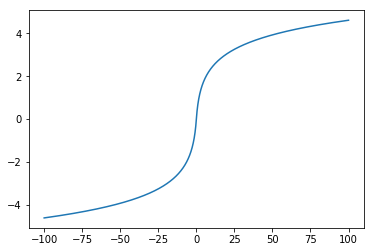

In [2]:
x = np.arange(-100, 100, .01)

y = np.log(np.abs(x)+1) * np.sign(x)

plt.plot(x, y)

In [3]:

def apply_clipped_optimizer(opt_fcn,
                            loss,
                            clip_norm=.1,
                            clip_single=.03,
                            clip_global_norm=False,
                            var_list=None):
    if var_list is None:
        gvs = opt_fcn.compute_gradients(loss)
    else:
        gvs = opt_fcn.compute_gradients(loss, var_list = var_list)
        

    if clip_global_norm:
        gs, vs = zip(*[(g, v) for g, v in gvs if g is not None])
        capped_gs, grad_norm_total = tf.clip_by_global_norm([g for g in gs],clip_norm)
        capped_gvs = list(zip(capped_gs, vs))
    else:
        grad_norm_total = tf.sqrt(
                tf.reduce_sum([
                        tf.reduce_sum(tf.square(grad)) for grad, var in gvs
                        if grad is not None
                ]))
        capped_gvs = [(tf.clip_by_value(grad, -1 * clip_single, clip_single), var)
                                    for grad, var in gvs if grad is not None]
        capped_gvs = [(tf.clip_by_norm(grad, clip_norm), var)
                                    for grad, var in capped_gvs if grad is not None]

    optimizer = opt_fcn.apply_gradients(capped_gvs)

    return optimizer, grad_norm_total

class MLP:
    def __init__(self,
                x, lshapes, output_units, namebase, tanh_out = False, sigmoid = False, squeeze = True,
                reuse = False,residual = None, use_bias = True
                ):
        self.namebase = namebase
        self.reuse = reuse
        self.lidx = 0
        name_fcn = self.get_name
        self.h = [tf.nn.leaky_relu(tf.layers.dense(
            x, lshapes[0], name=self.get_name(), reuse = self.reuse))]
        h2 = self.h[-1]
        for size in lshapes:
            self.h.append(tf.nn.leaky_relu(self.h[-1] + tf.layers.dense(
                self.h[-1], size, name=name_fcn(), reuse = self.reuse)))
        self.h2 = tf.concat(self.h[::2], -1)
        output = tf.layers.dense(
            self.h2, output_units, name=name_fcn(), reuse = self.reuse)
        if output_units == 1 and squeeze:
            output = tf.squeeze(output, -1)
        self.raw_output = output
        if residual is not None:
            self.raw_output = self.raw_output + residual
        if tanh_out:
            self.output = leaky_tanh(self.raw_output)
        elif sigmoid:
            self.output = tf.nn.sigmoid(self.raw_output) * 2. - 0.5
        else:
            self.output = self.raw_output
    def get_name(self):
        self.lidx = self.lidx + 1
        return self.namebase + str(self.lidx)

In [4]:

def make_maxmin(x):
    y = x.copy()
    y[maskh==0] = np.nan
    amin, amax = np.nanmin(y, (0, 1)), np.nanmax(y, (0,1))
    return amin, amax

def make_state(state, action, style = 'np'):
    together = FCNS[style]['concat']((state, action), -1)
    if style == 'tf':
        return together
#         expanded = FCNS[style]['expand'](
#             together, 1)
    else:
        expanded = FCNS[style]['expand'](
            together, 0)
    return expanded
    return FCNS[style]['reshape'](
        together, (state.shape[0], -1, state.shape[-1] + action.shape[-1]))
        
    

def accumulate_state(state, action, old_state, statedecay, style = 'np'):
    new_state = make_state(state, action, style)
    new_state_len = new_state.shape[-1]
    if style == 'tf':
        vel = new_state - old_state[:,:,0,:new_state_len]
    else:
        vel = new_state - old_state[0,:new_state_len]
    new_state = FCNS[style]['concat']((new_state, vel), -1)
    if style == 'tf':
        return FCNS[style]['concat']((tf.expand_dims(new_state, 2), old_state[:,:,:-1,:]*statedecay), 2)
    return FCNS[style]['concat']((new_state, old_state[:-1,:]*statedecay), 0)

def leaky_tanh(x):
    return tf.log(tf.abs(x)+1) * tf.sign(x)*.7
    #return tf.nn.tanh(x*30)/10 + tf.nn.tanh(x*2)/2 + tf.nn.tanh(x/20) * 2 + x * 1e-3

In [5]:

def get_grad_norm(optimizer, loss, optname):
    gvs = optimizer.compute_gradients(loss)
    grad_norm = tf.reduce_mean(
        [tf.reduce_mean(tf.square(grad)) for
         grad, var in gvs if grad is not None and optname in var.name])
    return grad_norm

In [6]:


class PolicyLearner(object):
    def __init__(self, ob_space, ac_space, take_weights_here=None, 
                 lshapes = [32 * SIZE_MULT] * N_LAYERS, config = None, 
                 lshapes_small = [32 * SIZE_MULT] * (N_LAYERS),
                 lshapes_smaller = [32 * SIZE_MULT] * (N_LAYERS),
                 lshapes_drop = [16 * SIZE_MULT] * N_DROP,
                reuse = False):
        self.sess = tf.InteractiveSession(config=config)
        self.obs_raw = tf.placeholder(tf.float32, (None, None, NUM_HISTORY, N_STATE))
        self.returns = tf.placeholder(tf.float32, (None, None))
        self.returnsdecayed = tf.placeholder(tf.float32, (None, None))
        self.mask = tf.placeholder(tf.float32, (None, None))
        self.lr = tf.placeholder_with_default(1e-3, (None))
        self.statesraw = tf.placeholder(tf.float32, (None, None, N_OBS))
        self.is_train = tf.placeholder_with_default(True, (None))
        self.is_exploit = tf.placeholder(tf.float32, (None))
        self.is_exploit2d = tf.expand_dims(self.is_exploit, -1)
        self.is_exploit3d = tf.expand_dims(self.is_exploit2d, -1)
        self.statesraw_expanded = tf.expand_dims(self.statesraw, -1)
        self.obs_raw_expanded = tf.expand_dims(self.obs_raw, -1)
        self.maskexpanded = tf.expand_dims(self.mask, -1)
        self.maskexpanded2 = tf.expand_dims(self.maskexpanded, -1)
        self.obs = tf.reshape(
            self.obs_raw, (
                tf.shape(self.obs_raw)[0], tf.shape(self.obs_raw)[1], N_STATE * NUM_HISTORY))
        self.actor = MLP(
            self.obs, lshapes, N_ACT, 'a_', squeeze = False, reuse = reuse,
        tanh_out = True)
        self.explorer = MLP(
            self.obs, lshapes, N_ACT, 'e_', squeeze = False, reuse = reuse,
        tanh_out = True)
        self.actions = self.actor.output
        self.explorer_actions = self.explorer.output
        self.state_value_estimator = MLP(
            self.obs, lshapes_smaller, 1, 'v_', reuse = reuse, sigmoid = True)
        self.state_value_estimate = self.state_value_estimator.output
        
        self.advantage = ((
            self.state_value_estimate[:,1:] * GAMMA + self.returns[:,:-1]) -
            self.state_value_estimate[:,:-1])
        
        self.critic_input = tf.concat((self.obs, self.actions), -1)
        self.explorer_critic_input = tf.concat((self.obs, self.explorer_actions), -1)
        
        self.advantage_estimator = MLP(
            self.critic_input, lshapes_small, 1, 'c_', reuse = reuse)
        self.model_estimator = MLP(
            self.critic_input, lshapes_small, N_OBS, 'm_', reuse = reuse,
            sigmoid = True
        )
        self.explorer_advantage_estimator = MLP(
            self.explorer_critic_input, lshapes_small, 1, 'c_', reuse = True)
        self.explorer_model_estimator = MLP(
            self.explorer_critic_input, lshapes_small, N_OBS, 'm_', reuse = True,
            sigmoid = True
        )
        self.advantage_estimate = self.advantage_estimator.output
        self.model_estimate = self.model_estimator.output
        self.future_obs_raw = accumulate_state(
            self.model_estimate, self.actions, self.obs_raw, STATE_DECAY, style = 'tf')
        self.explorer_future_obs_raw = accumulate_state(
            self.explorer_model_estimator.output, self.explorer_actions,
            self.obs_raw, STATE_DECAY, style = 'tf')
        
        self.future_obs = tf.reshape(self.future_obs_raw, 
            (tf.shape(self.future_obs_raw)[0],tf.shape(self.future_obs_raw)[1], N_STATE * NUM_HISTORY))
        self.explorer_future_obs = tf.reshape(self.explorer_future_obs_raw, 
            (tf.shape(self.explorer_future_obs_raw)[0],
             tf.shape(self.explorer_future_obs_raw)[1], N_STATE * NUM_HISTORY))
        
        self.future_value = MLP(
            self.future_obs, lshapes_smaller, 1, 'v_', reuse = True, sigmoid = True)
        
        self.future_actor = MLP(
            self.future_obs, lshapes, N_ACT, 'a_', reuse = True, squeeze = False, tanh_out = True)
        self.future_actions = self.future_actor.output
        
        self.future_critic_input = tf.concat((self.future_obs, self.future_actions), -1)
        self.future_advantage_estimator = MLP(
            self.future_critic_input, lshapes_small, 1, 'c_', reuse = True)
        
        if len(self.future_actions.shape) == 2:
            self.future_actions = tf.expand_dims(self.future_actions, -1)
        
        self.t_vars = tf.trainable_variables()
        self.a_vars = [var for var in self.t_vars if 'a_' in var.name]
        self.v_vars = [var for var in self.t_vars if 'v_' in var.name]
        self.c_vars = [var for var in self.t_vars if 'c_' in var.name]
        self.e_vars = [var for var in self.t_vars if 'e_' in var.name]
        self.m_vars = [var for var in self.t_vars if 'm_' in var.name]
        
        self.creg, self.areg, self.vreg, self.mreg, self.ereg = [
            tf.reduce_mean([tf.reduce_mean(tf.square(v)) for v in optvars]) * 1e-8
            for optvars in 
            [self.c_vars, self.a_vars, self.v_vars, self.m_vars, self.e_vars]]
        
        self.frac_not_masked = tf.reduce_mean(self.mask)
        
        self.e_loss_critic = -tf.reduce_sum(
            self.explorer_advantage_estimator.output * self.mask)/self.frac_not_masked

        self.model_state_estimate = self.model_estimator.output
        
        self.v_loss_raw = tf.reduce_mean(
            tf.square(self.returnsdecayed - self.state_value_estimate) * self.mask * self.is_exploit2d
        ) / tf.reduce_mean(self.mask * self.is_exploit2d) * 1e1
        self.m_loss_raw = tf.reduce_mean(tf.square(
            self.model_estimator.output[:,:-1] - self.statesraw[:,1:]
        ) * self.maskexpanded[:,:-1]) * 1e1
        
        self.c_loss_raw = tf.reduce_mean(tf.square(
            self.advantage_estimate[:,:-1] - self.advantage) * self.mask[:,:-1]) * 1e1
        
        self.a_mse = tf.reduce_mean((
            tf.square(self.actor.raw_output) * 1e1
            ) * self.maskexpanded)/tf.reduce_mean(self.maskexpanded)
        
        
        self.e_mse = tf.reduce_mean((
            tf.square(self.explorer.raw_output) * 1e1
            ) * self.maskexpanded)/tf.reduce_mean(self.maskexpanded)
        
        
        self.a_loss_critic = -tf.reduce_sum(
            self.advantage_estimator.output * self.mask)/self.frac_not_masked
        self.a_loss_model = -tf.reduce_sum(
            self.future_value.output * self.mask)/self.frac_not_masked
        self.a_loss_secondaction = -tf.reduce_sum(
            self.future_advantage_estimator.output * self.mask)/self.frac_not_masked
        
#         self.grad_v = tf.square(tf.gradients(
#             self.state_value_estimator.output * self.mask, self.obs)[0])
#         self.grad_m = tf.square(tf.gradients(
#             self.model_estimator.output * self.maskexpanded2, self.critic_input)[0])
#         self.grad_c = tf.square(tf.gradients(
#             self.advantage_estimator.output * self.maskexpanded, self.critic_input)[0])
        
#         self.grad_norm_m = tf.reduce_mean(self.grad_m) * 1e-12
#         self.grad_norm_v = tf.reduce_mean(self.grad_v) * 1e-12
#         self.grad_norm_c = tf.reduce_mean(self.grad_c) * 1e-12
    
#         slopes = tf.reduce_sum(tf.square(self.grad_c), reduction_indices=[2])
#         self.grad_c_1 = tf.reduce_mean(self.mask * (slopes - .2) ** 2) * 1e-17
#         slopes = tf.reduce_sum(tf.square(self.grad_m), reduction_indices=[2])
#         self.grad_m_1 = tf.reduce_mean(self.mask * (slopes - .2) ** 2) * 1e-13
        
        
        self.critic_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        self.value_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        self.actor_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        self.model_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        self.explorer_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        
        if TESTING_GRAD_NORMS:
            self.actor_current_mult = []
            self.critic_current_mult = []
            self.actor_loss_mults = []
            self.critic_loss_mults = []
            self.critic_loss_grads = []
            self.actor_loss_grads = []
            self.actor_loss_targets = np.array([10., 10., .1,
                                               10., 10.])
            self.actor_loss_names = ['a_loss_critic', 'a_loss_model', 'a_loss_secondaction', 
                        'explorer_adv_loss', 'explorer_mdl_loss'
                                    ]
            self.critic_loss_targets = np.array(
                [10, 1., 10,
                 .001, .001, .001, 
                .001, .001])
            self.critic_loss_names = [
                'v_loss_raw','m_loss_raw', 'c_loss_raw',
                'grad_norm_c',  'grad_norm_v', 'grad_norm_m', 
                'grad_m_1', 'grad_c_1']
            self.aopts = [self.actor_opt] * 3 + [self.explorer_opt] * 2
            self.aoptnames = ['a_'] * 3 + ['e_'] * 2
            self.copts = [self.value_opt, self.model_opt, self.critic_opt, 
                          self.critic_opt, self.value_opt,
                          self.model_opt, self.model_opt, self.critic_opt]
            self.coptnames = [v + '_' for v in ['v', 'm', 'c', 'c', 'v', 'm', 'm', 'c']]
            for lidx, loss in enumerate(self.actor_loss_names):
                opt = self.aopts[lidx]
                optname = self.aoptnames[lidx]
                loss_mult = tf.placeholder_with_default(1., (None))
                self.actor_loss_mults.append(loss_mult)
                setattr(self, loss, getattr(self, loss) * loss_mult)
                self.actor_loss_grads.append(get_grad_norm(opt, getattr(self, loss), optname))
                self.actor_current_mult.append(1)
            for lidx, loss in enumerate(self.critic_loss_names):
                opt = self.copts[lidx]
                optname = self.coptnames[lidx]
                loss_mult = tf.placeholder_with_default(1., (None))
                self.critic_loss_mults.append(loss_mult)
                setattr(self, loss, getattr(self, loss) * loss_mult)
                self.critic_loss_grads.append(get_grad_norm(opt, getattr(self, loss), optname))
                self.critic_current_mult.append(1)
            self.actor_current_mult = np.array(self.actor_current_mult)
            self.critic_current_mult = np.array(self.critic_current_mult)
        
        self.v_loss =  self.v_loss_raw + self.vreg
        self.m_loss = self.m_loss_raw + self.mreg
        self.c_loss =  self.c_loss_raw + self.creg
        self.aregtotal = self.areg + self.a_mse
        self.a_loss_raw = self.a_loss_critic + self.a_loss_model + \
            self.a_loss_secondaction
        self.a_loss = self.a_loss_raw + self.aregtotal
        
        
        self.e_loss_minimize = self.e_loss_critic + \
            self.e_mse + self.ereg
        self.a_loss_minimize = self.a_loss
        self.c_loss_minimize = self.c_loss# + self.grad_norm_c + self.grad_c_1
        self.v_loss_minimize = self.v_loss# + self.grad_norm_v
        self.m_loss_minimize = self.m_loss# + self.grad_norm_m + self.grad_m_1
        
        
        if TESTING_GRAD_NORMS:
            self.a_grads = [
                get_grad_norm(self.actor_opt, l) for l in [
                self.a_loss_minimize, self.a_loss_raw, self.a_loss_critic,self.a_loss_model,
                self.a_loss_secondaction,
                self.areg, self.aregmeanbyaction, self.actstdpenalty, self.a_mse
            ]]
            self.v_grads = [get_grad_norm(self.value_opt, l) for l in [
                self.v_loss_minimize, self.v_loss_raw, 
                self.vreg, self.grad_norm_v
            ]]
            self.c_grads = [get_grad_norm(self.critic_opt, l) for l in [
                self.c_loss_minimize, self.c_loss_raw, 
                self.creg, self.grad_norm_c, self.grad_c_1

            ]]
            self.m_grads = [get_grad_norm(self.critic_opt, l) for l in [
                self.m_loss_minimize, self.m_loss_raw, 
                self.mreg, self.grad_norm_m, self.grad_m_1
            ]]
        
        self.copt, self.c_norm = apply_clipped_optimizer(
            self.critic_opt, self.c_loss_minimize, var_list = self.c_vars)
        self.vopt, self.v_norm = apply_clipped_optimizer(
            self.value_opt, self.v_loss_minimize, var_list = self.v_vars)
        self.aopt, self.a_norm = apply_clipped_optimizer(
            self.actor_opt, self.a_loss_minimize, var_list = self.a_vars)
        self.mopt, self.m_norm = apply_clipped_optimizer(
            self.model_opt, self.m_loss_minimize, var_list = self.m_vars)
        self.eopt, self.e_norm = apply_clipped_optimizer(
            self.explorer_opt, self.e_loss_minimize, var_list = self.e_vars)

    def a_name(self):
        self.a_idx += 1
        return 'a_' + str(self.a_idx)
    def c_name(self):
        self.c_idx += 1
        return 'c_' + str(self.c_idx)
    def v_name(self):
        self.v_idx += 1
        return 'v_' + str(self.v_idx)
    def m_name(self):
        self.m_idx += 1
        return 'm_' + str(self.m_idx)
    def e_name(self):
        self.e_idx += 1
        return 'e_' + str(self.e_idx)
    
    def load_weights(self):
        feed_dict = {}
        for (var, w), ph in zip(
            self.assigns, self.weight_assignment_placeholders):
            feed_dict[ph] = w
        self.sess.run(self.weight_assignment_nodes, feed_dict=feed_dict)

    def act(self, obs, exploit = True):
        # Because we need batch dimension, 
        # data[None] changes shape from [A] to [1,A]
        if exploit:
            act = self.actions
        else:
            act = self.explorer_actions
        a = self.sess.run(
            act, feed_dict={
                self.obs_raw:np.reshape(obs/shdiff - shmin_g_e, (1, 1, N_HISTORY, N_STATE)),
                self.is_train:False
            })
        return a[0][0]  # return first in batch



config = tf.ConfigProto(
    inter_op_parallelism_threads=0,
    intra_op_parallelism_threads=0,
    device_count = { "GPU": 0 } )
tf.reset_default_graph()

pi = PolicyLearner(env.observation_space, env.action_space, config = config)

sess = pi.sess
self = pi
sess.run(tf.global_variables_initializer())
#trainer = ZooPolicyTensorflow(
# "mymodel1", env.observation_space, env.action_space)
saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [7]:
# env.close()


# env = gym.make(envname)

In [8]:
if TESTING_GRAD_NORMS:
    self.actor_current_mult = np.ones_like(self.actor_current_mult,dtype=np.float32)
    self.critic_current_mult = np.ones_like(self.critic_current_mult,dtype=np.float32)

In [9]:

#         self.advantage = ((
#             self.stateraw_value_estimate[:,1:] * GAMMA + self.returns) -
#             self.state_value_estimate[:,:-1])

In [10]:

ah, sh, shraw, rh, rdecayedh, maskh = [
    np.zeros((0, 0, i)) for i in [N_ACT, INPUT_UNITS, N_OBS, 1, 1, 1]]
isexploit = []
globalframes = []
localframes = []
ep = 0
trained = 0
ongoing = 0
printfreq = 20
obj_fname = envname + str(PERCENT_CHOOSE_OPTIMAL) + 'saveobjs_unguided.pkl'
tffile = "tmp/" + envname + str(PERCENT_CHOOSE_OPTIMAL) + "unguided_trained.ckpt"
import pickle

In [11]:
ongoing = 0
sess.run(tf.global_variables_initializer())

In [12]:

def train_actor(self, feed_dict, printon):
    _, _, aloss = sess.run(
        [self.aopt, self.eopt, self.a_loss],
        feed_dict = feed_dict
            )
    if TESTING_GRAD_NORMS and ep % printfreq == 0 and printon and ep > INIT_LEN:
        cur_grad_norms = sess.run(self.actor_loss_grads, feed_dict)
        target = self.actor_loss_targets
        problem_factor = cur_grad_norms / target
        for fidx, factor in enumerate(problem_factor):
            if fidx == len(problem_factor) - 1:
                pass
            if factor > 1000:
                self.actor_current_mult[fidx] = self.actor_current_mult[fidx] / 30
            elif factor > 100:
                self.actor_current_mult[fidx] = self.actor_current_mult[fidx] / 10
            elif factor > 10:
                self.actor_current_mult[fidx] = self.actor_current_mult[fidx] / 3
            elif factor < .001:
                self.actor_current_mult[fidx] = self.actor_current_mult[fidx] * 30
            elif factor < .01:
                self.actor_current_mult[fidx] = self.actor_current_mult[fidx] * 10
            elif factor < .1:
                self.actor_current_mult[fidx] = self.actor_current_mult[fidx] * 3
            self.actor_current_mult[fidx] = np.clip(self.actor_current_mult[fidx], 1e-5, 1e5)
        print(list(zip(self.actor_loss_names, cur_grad_norms, target, self.actor_current_mult)))
    return aloss

In [13]:
def train(actor = True, value = True, n_steps = 1, forced_hist = 2):
    for itr in range(n_steps):
        if num_hist >  batch_size:
            #probability = np.arange(num_hist - forced_hist)
            probability = num_steps_per_run = (
                maskh.shape[1] - maskh[:,::-1].argmax(1))
            if forced_hist:
                probability = probability[:-forced_hist]
            probability = np.sqrt(probability)
            probability = probability / probability.sum()
            rnd = np.random.choice(
                    num_hist - forced_hist, batch_size - forced_hist, 
                    replace=False, p=probability)
            if forced_hist:
                samples = np.concatenate((rnd,
                    np.arange( num_hist - forced_hist, num_hist)))
            else:
                samples=rnd
        else:
            samples = np.random.choice(num_hist, num_hist, replace=False)
        #samples = np.array([-2, -1])
        actions, states, statesraw, returns, returnsdecayed, mask, exploit = [
            v[samples] for v in [ah, sh, shraw, rh,rdecayedh, maskh, np.array(isexploit)]]
        feed_dict={
                    self.returns:(returns - vmin_g_e) / vdiff,
                    self.statesraw: (statesraw- shrawmin_g_e) / shrawdiff ,
                    self.returnsdecayed:(returnsdecayed - vmin_g_e) / vdiff,
                    self.lr: .02 / np.power(ep + 20, .4),
                    self.mask:mask,
                    self.obs_raw: (
                        (states - shmin_g_e)/shdiff).reshape(*states.shape[:2], N_HISTORY, N_STATE),
                    self.is_exploit:exploit,
                    self.actions:actions
        }
        if TESTING_GRAD_NORMS:
            for lph, lmult in zip(self.actor_loss_mults, self.actor_current_mult):
                feed_dict[lph] = lmult
            for lph, lmult in zip(self.critic_loss_mults, self.critic_current_mult):
                feed_dict[lph] = lmult
            self.amse_mult = 1.
            self.emse_mult = 1.
        if value:
            if exploit.sum() > 1:
                _,_, _, mloss, closs, vloss = sess.run(
                    [self.mopt, self.copt,self.vopt, self.m_loss, self.c_loss, self.v_loss],
                        feed_dict=feed_dict)
            else:
                _, mloss = sess.run(
                    [self.mopt, self.m_loss],
                        feed_dict=feed_dict)
                closs = vloss = 0
        else:
            mloss = closs =  vloss = 0
        del feed_dict[self.actions]
        if actor and exploit.sum() > 1:
            aloss = train_actor(self, feed_dict, printon = itr == 0)
        else:
            aloss = 0
    if 1:
        if ep % printfreq == 0 and exploit.sum() > 1:
            print('aloss', aloss, 'closs', closs, 'vloss', vloss, 'mloss', mloss)
            if TESTING_GRAD_NORMS and ep > INIT_LEN:
                
                cur_grad_norms = sess.run(self.critic_loss_grads, feed_dict)
                target = self.critic_loss_targets
                problem_factor = cur_grad_norms / target
                for fidx, factor in enumerate(problem_factor):
                    if factor > 1000:
                        self.critic_current_mult[fidx] = self.critic_current_mult[fidx] / 30
                    elif factor > 100:
                        self.critic_current_mult[fidx] = self.critic_current_mult[fidx] / 10
                    elif factor > 10:
                        self.critic_current_mult[fidx] = self.critic_current_mult[fidx] / 2
                    elif factor < .001:
                        self.critic_current_mult[fidx] = self.critic_current_mult[fidx] * 30
                    elif factor < .01:
                        self.critic_current_mult[fidx] = self.critic_current_mult[fidx] * 10
                    elif factor < .1:
                        self.critic_current_mult[fidx] = self.critic_current_mult[fidx] * 2
                print(list(zip(
                    self.critic_loss_names, cur_grad_norms, target, self.critic_current_mult)))
    if ep % printfreq == 0:
        print(' ep, ', ep, ' avg frames',np.mean(globalframes[-20:]))
        print('abs action',np.abs(ah)[-1,0,:].shape, np.abs(ah)[-1,0,:].mean())
        print('max reward',np.max(rh[-10:,10:]))
    if ep % 10000 == 0:
        clear_output()
    if ep % 100 == 0:
        ysmoothed = gaussian_filter1d(globalframes, sigma=4)
        plt.plot(ysmoothed)
        plt.show()
    return feed_dict

In [14]:
trained = 0
exploit = 0

In [15]:
trained, ongoing

(0, 0)

In [16]:
if ongoing:
    
    save_path = saver.save(sess, tffile)
    print('saved at epoch', ep)
    with open(obj_fname,"wb") as f:
        pickle.dump(
            [ah, sh, shraw, rh, rdecayedh, maskh, ep, globalframes, isexploit
            ], f)
    trained = 1

score 58.0  frames 29
saved at epoch 100
saved at epoch 200
aloss -1617.8889 closs 0.2002377 vloss 4.317632 mloss 7.073284
 ep,  220  avg frames 13.096782178217822
abs action (1,) 1.8809690475463867
max reward 2.0
aloss 216.73529 closs 0.0060611987 vloss 6.8438144 mloss 5.4585404
 ep,  240  avg frames 13.8
abs action (1,) 0.7783200144767761
max reward 2.0
aloss 299.13812 closs 0.0054663215 vloss 4.5255384 mloss 4.9972334
 ep,  260  avg frames 15.0
abs action (1,) 0.8562057614326477
max reward 2.0
 ep,  280  avg frames 14.95
abs action (1,) 0.9140107679603559
max reward 2.0
saved at epoch 300
aloss -43.173164 closs 0.003447727 vloss 6.8456244 mloss 4.446568
 ep,  300  avg frames 13.05
abs action (1,) 1.0381301641464233
max reward 2.0


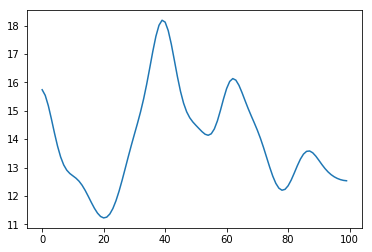

aloss -22.651556 closs 0.0016653334 vloss 4.8140435 mloss 4.173182
 ep,  320  avg frames 15.2
abs action (1,) 1.8976515958815419
max reward 2.0
aloss 145.27359 closs 0.0014851899 vloss 6.72818 mloss 4.2089615
 ep,  340  avg frames 15.0
abs action (1,) 1.0727441310882568
max reward 2.0
aloss 169.63081 closs 0.0015874885 vloss 5.0741334 mloss 4.3165107
 ep,  360  avg frames 13.45
abs action (1,) 0.17454436421394348
max reward 2.0
aloss 96.65018 closs 0.00067906274 vloss 6.726307 mloss 4.2367773
 ep,  380  avg frames 15.1
abs action (1,) 0.4445543885231018
max reward 2.0
saved at epoch 400
aloss 191.49472 closs 0.0018461338 vloss 5.9746637 mloss 4.147624
 ep,  400  avg frames 14.0
abs action (1,) 1.3078941106796265
max reward 2.0


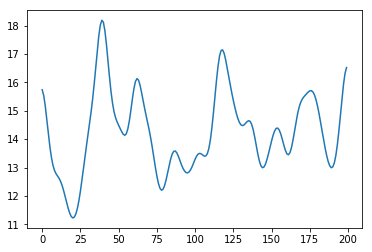

aloss 141.96861 closs 0.00096107455 vloss 4.9474673 mloss 4.1682034
 ep,  420  avg frames 17.0
abs action (1,) 0.6333432793617249
max reward 2.0
aloss 72.979004 closs 0.00061100157 vloss 4.8536873 mloss 4.148094
 ep,  440  avg frames 13.8
abs action (1,) 0.7643067836761475
max reward 2.0


KeyboardInterrupt: 

In [17]:
if trained:
    try:
        saver.restore(sess, tffile)
        with open(obj_fname, "rb") as f:
            ah, sh, shraw, rh, rdecayedh, maskh, ep, globalframes, isexploit = pickle.load(f)
        print('restored from save file')
    except:
        print('no save file detected')
        trained = 0
else:

    [[shrawmin_g, shrawmax_g],
        [shmin_g, shmax_g],
        [vmin_g, vmax_g]] = [[
        np.ones(i) * 1000, np.zeros(i) * -1000] for i in [N_OBS, N_STATE * N_HISTORY, 1]]
MAX_SEQ_LEN = 5000
for ep in range(ep, 10000000):
    if ep % 100 == 0 and trained and ep > 0:
        save_path = saver.save(sess, tffile)
        print('saved at epoch', ep)
        with open(obj_fname,"wb") as f:
            pickle.dump(
                [ah[-NUM_KEEP:], sh[-NUM_KEEP:], shraw[-NUM_KEEP:],
                 rh[-NUM_KEEP:], rdecayedh[-NUM_KEEP:], maskh[-NUM_KEEP:], ep, globalframes, isexploit[-NUM_KEEP:]
                ], f)
    if ep % 20 == 5:
        shrawmin, shrawmax = make_maxmin(shraw)
        shmin, shmax = make_maxmin(sh)
        vmin, vmax = make_maxmin(rdecayedh)
        shrawmin_g, shmin_g, vmin_g = [
            np.minimum(g, n) for g, n in zip(
                [shrawmin_g, shmin_g, vmin_g], [shrawmin, shmin, vmin])]
        shrawmax_g, shmax_g, vmax_g = [
            np.maximum(g, n) for g, n in zip(
                [shrawmax_g, shmax_g, vmax_g], [shrawmax, shmax, vmax])]

        [shrawmin_g_e, shrawmax_g_e,
        shmin_g_e, shmax_g_e
        ] = [np.reshape(v, (1, 1, -1)) for v in [shrawmin_g, shrawmax_g,
                                shmin_g, shmax_g,
                                ]]
        vmin_g_e, vmax_g_e = [np.reshape(v, (1, 1)) for v in [vmin_g, vmax_g]]

        shrawdiff = shrawmax_g_e - shrawmin_g_e
        shdiff = shmax_g_e - shmin_g_e
        vdiff = vmax_g_e - vmin_g_e
    trained = 1
    ongoing = 1
    
    an, sn, snraw, rn, rdecayedn, maskn = [
        np.zeros((0, i)) for i in [N_ACT, INPUT_UNITS, N_OBS, 1, 1, 1]]
    frame = 0
    score = 0
    restart_delay = 5
    obs = env.reset()
    obsraw = obs
    snraw = np.concatenate((snraw, obs.reshape(1, -1)), 0)
    obs = np.concatenate((obs, np.zeros(N_ACT)))
    obs = np.concatenate((obs, np.zeros_like(obs)))
    obs_mat = np.concatenate((
        obs[None,:],np.zeros((NUM_HISTORY-1, N_STATE))), 0)
    rn = [0]
    done_ctr = 0
    sn = np.concatenate((sn, obs_mat.reshape(1, -1)), 0)
    step_num = 0
    step_shifted = -1
    show_shift = 0
    if ep <= INIT_LEN or exploit:
        exploit = 0
    else:
        exploit = 1
    while 1:
        step_num += 1
        if ep < INIT_LEN:
            a = np.random.randn(N_ACT)
        else:
            a = pi.act(obs_mat.flatten(), exploit = exploit)
            if (not exploit) and np.random.rand() < .2:
                a = np.random.randn(*a.shape) * 2
        an = np.concatenate((an, a[None,:]), 0)
        snraw = np.concatenate((snraw, obsraw[None,:]), 0)
        last_obs = obs
#         last_obsraw = obsraw
        obs, r, done, _ = env.step(a)
        obsraw = obs
        r = r + 1 * REWARD_MULT

        obs_mat = accumulate_state(
            obs, a, obs_mat, STATE_DECAY, style = 'np')
        
        rn.append(r)
        sn = np.concatenate((sn, obs_mat.reshape(1, -1)), 0)
        score += r
        frame += 1
        if ep > INIT_LEN:
            still_open = 1#env.render("human")
        else:
            still_open = 1
        if done:
            done_ctr += 1
            if done_ctr > 3:
                if ep % MAX_SEQ_LEN == 0:
                    print('score', score, ' frames', frame)
                break
        if still_open==False:
            crashhere
        if not done: continue
        if restart_delay==0:
            print("score=%0.2f in %i frames" % (score, frame))
            if still_open!=True:      # not True in multiplayer or non-Roboschool 
                break
            restart_delay = 2000*2  # 2 sec at 60 fps
        restart_delay -= 1
        if restart_delay==0: 
            break
    if ep < INIT_LEN:
        a = np.random.randn(N_ACT)
    else:
        a = pi.act(obs_mat.flatten())
    an = np.concatenate((an, a[None,:]), 0)
    localframes.append(frame)
    rn = np.array(rn)
    rn[-1] = rn[-1] - 20 * REWARD_MULT
    rewards = [0]
    for ir in rn[::-1]:
        rewards.append(rewards[-1] * GAMMA + ir)
    rdecayedn = np.array(rewards)[:0:-1]
    lenrdec = len(rdecayedn)
#     rdecayedn = rdecayedn + lenrdec
#     rdecayedn = rdecayedn - np.arange(lenrdec) * 1.8
    maskn = np.ones_like(rn)
    if step_shifted > -1:
        if step_shifted == 0:
            raise ValueError('step shifted not allowed 0')
        maskn[:step_shifted - 1] = 0
    if ep == 0:
        ah, sh, shraw, rh, rdecayedh, maskh = [
            np.expand_dims(v, 0) for v in [an, sn, snraw, rn,rdecayedn, maskn]]
        isexploit = [exploit]
    else:
        def get_updated_h(h, n, third_dim):
            hshape = h.shape[1]
            nshape = n.shape[0]
            if third_dim:
                if hshape > nshape:
                    n = np.concatenate((n, np.zeros((hshape - nshape, n.shape[-1]))), 0)
                if nshape > hshape:
                    h = np.concatenate((h, np.zeros((
                        h.shape[0], nshape - hshape, h.shape[-1]))), 1)
            else:
                if hshape > nshape:
                    n = np.concatenate((n, np.zeros((hshape - nshape))), 0)
                if nshape > hshape:
                    h = np.concatenate((h, np.zeros((h.shape[0], nshape - hshape))), 1)
            h = np.concatenate((h, np.expand_dims(n, 0)), 0)
            return h
            
        ah, sh, shraw = [get_updated_h(h, n, 1) for  h, n in zip(
            [ah, sh, shraw], [an, sn, snraw])]
        
        rh, rdecayedh, maskh = [
            get_updated_h(h, n, 0) for h, n in zip(
                [rh, rdecayedh, maskh], [rn, rdecayedn, maskn])]
        isexploit.append(exploit)
    if ep % 1 == 0 and ep > INIT_LEN:
        ah, sh, shraw, rh,rdecayedh, maskh, isexploit = [
            v[-NUM_KEEP:] for v in [ah, sh, shraw, rh,rdecayedh, maskh, isexploit]]
        globalframes.append(np.mean(localframes))
        localframes = []
        batch_size = 32
        if ep < batch_size:
            batch_size = ep
        num_hist = ah.shape[0]
        if ep == INIT_LEN + 1 or sum(isexploit) < 2:
            train(actor = False, n_steps = N_PRETRAIN, forced_hist=0)
            #train(value = False, n_steps = 20, forced_hist=0)
        elif ep < 200:
            feed_dict = train(actor = True, value = True, n_steps = 2)
        else:
            feed_dict = train(actor = True, value = True, n_steps = 4)


In [ ]:
ep = 220

In [ ]:
mvars2 = sess.run(self.m_vars)

In [ ]:
for m1, m2 in zip(mvars, mvars2):
    print(np.square(m1 - m2).mean())

In [ ]:
N_STATE * N_HISTORY

In [ ]:
self.m_vars

In [18]:
sess.run(self.model_estimate, feed_dict)

array([[[ 0.6144209 ,  0.44317448,  0.9548013 ,  0.48277986,
          0.49301046],
        [ 0.63579667,  0.46894562,  1.0566735 ,  0.45327586,
          0.4677779 ],
        [ 0.62210655,  0.46657294,  1.0931842 ,  0.4816479 ,
          0.46721   ],
        ...,
        [-0.5       ,  1.5       , -0.5       , -0.5       ,
         -0.5       ],
        [-0.5       ,  1.5       , -0.5       , -0.5       ,
         -0.5       ],
        [-0.5       ,  1.5       , -0.5       , -0.5       ,
         -0.5       ]],

       [[ 0.6123295 ,  0.43998015,  0.91223705,  0.44554806,
          0.4875641 ],
        [ 0.63284516,  0.4634989 ,  1.0091336 ,  0.36763775,
          0.4616809 ],
        [ 0.6044657 ,  0.4343124 ,  1.0224062 ,  0.35483372,
          0.47284675],
        ...,
        [-0.5       ,  1.5       , -0.5       , -0.5       ,
         -0.5       ],
        [-0.5       ,  1.5       , -0.5       , -0.5       ,
         -0.5       ],
        [-0.5       ,  1.5       , -0.5       , 

In [19]:
sess.run(self.model_estimate, feed_dict)[:,5:10]

array([[[ 0.646317  ,  0.50800776,  1.1252975 ,  0.46558964,
          0.42115915],
        [ 0.65245163,  0.51687336,  1.1267374 ,  0.45725024,
          0.41368645],
        [ 0.65809333,  0.5261431 ,  1.1273394 ,  0.44665354,
          0.4047758 ],
        [ 0.6642535 ,  0.53643656,  1.1278673 ,  0.43394107,
          0.3938675 ],
        [ 0.6708431 ,  0.5472721 ,  1.1268642 ,  0.4193617 ,
          0.38219506]],

       [[ 0.5997964 ,  0.42232734,  1.0231711 ,  0.35731208,
          0.48312312],
        [ 0.59722936,  0.41893232,  1.0248928 ,  0.3578714 ,
          0.48559988],
        [ 0.5949218 ,  0.41566557,  1.0272527 ,  0.359367  ,
          0.48792225],
        [ 0.59262085,  0.41251487,  1.0297998 ,  0.36129606,
          0.49040478],
        [ 0.5903641 ,  0.40947115,  1.0324001 ,  0.36360812,
          0.49291033]],

       [[ 0.62115145,  0.46978623,  1.0857095 ,  0.55706275,
          0.47256052],
        [ 0.63525486,  0.48911017,  1.1026902 ,  0.55762565,
          0

In [23]:
feed_dict[self.lr] = .0001

In [27]:
for _ in range(10):
    print(sess.run([self.mopt, self.m_loss], feed_dict))

[None, 4.08649]
[None, 4.0864615]
[None, 4.0862827]
[None, 4.0861855]
[None, 4.086071]
[None, 4.0859785]
[None, 4.0858517]
[None, 4.0858235]
[None, 4.0856876]
[None, 4.085637]


In [ ]:
for _ in range(30):
    train(actor = True, value = True, n_steps = 4)